# Paper Clip Counting

The dataset asks you to count paperclips on sheets of paper. Image counting applications are common for many sorts of data analysis. Images such as you see on Google Maps are frequent targets. Counting cars, people, trees, houses, water coverage, can all provide valuable information about the demographics of these regions.

For this competition you are given images of paper covered by paperclips. Your task is to count the paperclips and return as accurate of a count as possible. The images are 256x256.

[Dataset link](https://www.kaggle.com/jeffheaton/count-the-paperclips)

Some images are very easy:
<img src="https://data.heatonresearch.com/kaggle/images/clips-49994.png"/>

Some images will be really challenging:
<img src="https://data.heatonresearch.com/kaggle/images/clips-49973.png"/>

# Solutions:
1. CNN Network with linear output layer - loss: mean_squared_error.
2. MobileNetV2 with linear output layer - loss: mean_squared_error.

# Challenges:
- Use DataFrame to research images path.

In [1]:
#importing dependencies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
train = pd.read_csv('/kaggle/input/count-the-paperclips/train.csv', na_values=['NA', '?'])

In [3]:
train['filename']="clips-"+train["id"].astype(str)+".png"

In [4]:
train.head()

,id,clip_count,filename
0,30001,11,clips-30001.png
1,30002,2,clips-30002.png
2,30003,26,clips-30003.png
3,30004,41,clips-30004.png
4,30005,49,clips-30005.png


In [5]:
TRAIN_PCT = 0.9
TRAIN_CUT = int(len(train) * TRAIN_PCT)

df_train = train[0:TRAIN_CUT]
df_validate = train[TRAIN_CUT:]

In [6]:
#Directory with all images
IMAGES_DIR = "/kaggle/input/count-the-paperclips/clips-data-2020/clips"

#Data generator
training_datagen = ImageDataGenerator(
  rescale = 1./255,
  horizontal_flip=True,
  vertical_flip=True,
  fill_mode='nearest')
# Using the dataframe cols to research into the directory
train_generator = training_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=IMAGES_DIR,
        x_col="filename",
        y_col="clip_count",
        target_size=(256, 256),
        batch_size=32,
        class_mode='other')

validation_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = validation_datagen.flow_from_dataframe(
        dataframe=df_validate,
        directory=IMAGES_DIR,
        x_col="filename",
        y_col="clip_count",
        target_size=(256, 256),
        class_mode='other')

Found 18000 validated image filenames.
Found 2000 validated image filenames.


In [9]:
model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])


model.summary()
epoch_steps = 250 # needed tf for 2.2
validation_steps = len(df_validate)
model.compile(loss = 'mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto',
        restore_best_weights=True)
history = model.fit(train_generator,  
  verbose = 1, 
  validation_data=val_generator, callbacks=[monitor], epochs=25,
steps_per_epoch=epoch_steps, validation_steps=validation_steps) # needed for tf 2.2

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               125960704 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5

In [ ]:
model.save('model1.h5')

In [21]:
test = pd.read_csv(
    "/kaggle/input/count-the-paperclips/test.csv", 
    na_values=['NA', '?'])

test['filename']="clips-"+test["id"].astype(str)+".png"

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = validation_datagen.flow_from_dataframe(
        dataframe=test,
        directory=IMAGES_DIR,
        x_col="filename",
        batch_size=1,
        shuffle=False,
        target_size=(256, 256),
        class_mode=None)
test_generator.reset()
pred = model.predict(test_generator,steps=len(test))
df_submit = pd.DataFrame({'id':test['id'],'clip_count':pred.flatten()})
df_submit.to_csv("submit_model1.csv",index=False)

Found 5000 validated image filenames.


# Model 2 - Transfer-Learning

In [27]:
#erasing variables - to avoid problems :D
try:
    del train
    del df_train
    del df_validade
    del training_datagen
    del train_generator
    del validation_datagen
    del val_generator
    del model
    del test
except:
    pass

In [37]:

#using transfer learning
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))
#Setting the network to do not train again (native layers)
feature_extractor_layer.trainable = False

#Creating our model
model = tf.keras.Sequential([
  feature_extractor_layer,
    tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_11 (Dense)             (None, 512)               655872    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
Total params: 2,914,369
Trainable params: 656,385
Non-trainable params: 2,257,984
_________________________________________________________________


In [38]:
#loading again train.
train = pd.read_csv('/kaggle/input/count-the-paperclips/train.csv', na_values=['NA', '?'])
train['filename']="clips-"+train["id"].astype(str)+".png"

TRAIN_PCT = 0.9
TRAIN_CUT = int(len(train) * TRAIN_PCT)

df_train = train[0:TRAIN_CUT]
df_validate = train[TRAIN_CUT:]

#Directory with all images
IMAGES_DIR = "/kaggle/input/count-the-paperclips/clips-data-2020/clips"

#Data generator
training_datagen = ImageDataGenerator(
  rescale = 1./255,
  horizontal_flip=True,
  vertical_flip=True,
  fill_mode='nearest')
# Using the dataframe cols to research into the directory
train_generator = training_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=IMAGES_DIR,
        x_col="filename",
        y_col="clip_count",
        target_size=(224, 224),
        batch_size=32,
        class_mode='other')

validation_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = validation_datagen.flow_from_dataframe(
        dataframe=df_validate,
        directory=IMAGES_DIR,
        x_col="filename",
        y_col="clip_count",
        target_size=(224, 224),
        class_mode='other')

Found 18000 validated image filenames.
Found 2000 validated image filenames.


In [39]:
epoch_steps = 250 # needed for tf 2.2
validation_steps = len(df_validate)
model.compile(loss = 'mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto',
        restore_best_weights=True)
history = model.fit(train_generator,  
  verbose = 1, 
  validation_data=val_generator, callbacks=[monitor], epochs=25,
steps_per_epoch=epoch_steps, validation_steps=validation_steps) # needed for tf 2.2

Epoch 1/25
250/250 [==============================] - 41s 153ms/step - loss: 198.9263 - val_loss: 16.4523
Epoch 2/25
250/250 [==============================] - 30s 121ms/step - loss: 15.4597
Epoch 3/25
250/250 [==============================] - 30s 120ms/step - loss: 12.3394
Epoch 4/25
250/250 [==============================] - 30s 121ms/step - loss: 11.3041
Epoch 5/25
250/250 [==============================] - 31s 123ms/step - loss: 11.8995
Epoch 6/25
250/250 [==============================] - 30s 121ms/step - loss: 10.8770
Epoch 7/25
250/250 [==============================] - 30s 120ms/step - loss: 10.9407
Epoch 8/25
250/250 [==============================] - 30s 119ms/step - loss: 10.3780
Epoch 9/25
250/250 [==============================] - 30s 120ms/step - loss: 10.0580
Epoch 10/25
250/250 [==============================] - 30s 120ms/step - loss: 10.4965
Epoch 11/25
250/250 [==============================] - 30s 118ms/step - loss: 9.6224
Epoch 12/25
250/250 [======================

In [40]:
test = pd.read_csv(
    "/kaggle/input/count-the-paperclips/test.csv", 
    na_values=['NA', '?'])

test['filename']="clips-"+test["id"].astype(str)+".png"

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = validation_datagen.flow_from_dataframe(
        dataframe=test,
        directory=IMAGES_DIR,
        x_col="filename",
        batch_size=1,
        shuffle=False,
        target_size=(224, 224),
        class_mode=None)
test_generator.reset()
pred = model.predict(test_generator,steps=len(test))
df_submit = pd.DataFrame({'id':test['id'],'clip_count':pred.flatten()})
df_submit.to_csv("submit_model2.csv",index=False)

Found 5000 validated image filenames.


In [58]:
test_generator.reset()
img_test = test_generator.next()

In [59]:
img_test_3dim = img_test.reshape(224, 224, 3)

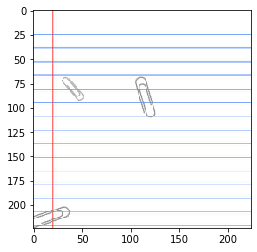

In [60]:
from matplotlib import pyplot as plt
plt.imshow(img_test_3dim, interpolation='nearest')
plt.show()

In [61]:
model.predict(img_test)

array([[3.2901273]], dtype=float32)